# Lab 06: Soft Actor-Critic

This lab looks into solving a continuous control problem using the actor-critic method: Soft Actor-Critic (SAC)

- Given the environment, that you can rollout, find a policy $\pi(a | s)$ that maximizes the objective and the actions entropy.
- The latter shall ensure policy robustnes to disturbances in the environment.

We solve the Pendulum problem, shown below, in following steps

1. Define the actor-critic's models,
2. Implement the SAC's update,
3. Train the policy.

Code based on: https://github.com/awarelab/spinningup_tf2

In [ ]:
# Installing dependencies
!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

In [ ]:
import glob
import time

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch

from base64 import b64encode
from IPython.display import HTML
from pyvirtualdisplay import Display


# Seed random generators
torch.manual_seed(42)
np.random.seed(42)

# Parameters
hidden_sizes=(64, 64) # Actor and critic networks sizes
total_steps=20_000 # Number of environment interactions to run and train on
replay_size=20_000 # Maximum length of replay buffer
gamma=0.99 # Discount factor (Always between 0 and 1.)
polyak=0.995 # Interpolation factor in polyak averaging for target networks
lr=0.001 # Learning rate (used for both policy and value learning)
alpha=0.2 # Entropy regularization coefficient (Equivalent to inverse of reward scale in the original SAC paper)
batch_size=256 # Minibatch size for SGD
start_steps=1_000 # Warm-up steps (uniform-random actions) before running real policy
update_after=512 # Number of env interactions to collect before starting to do gradient descent updates (Ensures replay buffer is full enough for useful updates)
update_every=50 # Number of env interactions that should elapse between gradient descent updates
max_ep_len=200 # Maximum length of trajectory / episode / rollout
num_test_episodes=30 # Number of episodes to test the deterministic policy at the end of training

# Constants
EPS = 1e-8

LOG_STD_MAX = 2
LOG_STD_MIN = -20

# Helpers

def show_video(file_name):
    mp4 = open(file_name,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=480 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

class ReplayBuffer:
    """A simple FIFO experience replay buffer for SAC agents."""

    def __init__(self, obs_dim, act_dim, size):
        self.obs1_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.obs2_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, act_dim], dtype=np.float32)
        self.rews_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs1_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        return dict(obs1=torch.Tensor(self.obs1_buf[idxs]),
                    obs2=torch.Tensor(self.obs2_buf[idxs]),
                    acts=torch.Tensor(self.acts_buf[idxs]),
                    rews=torch.Tensor(self.rews_buf[idxs]),
                    done=torch.Tensor(self.done_buf[idxs]))

# 0. The Pendulum environment

- The goal is to flip and balance the pendulum straight upwards.
- The observations are cosine and sine of the pendulum angular position, and its angular velocity.
- The actions is torque at the joint.
- The reward is the sum of the cost for the deviation from the zero position and velocity, and the action cost.
    Therefore, it's always negative and we want to minimize it.

Below is the evaluation presenting random policy acting on the pendulum.

In [ ]:
np.bool8 = np.bool_

env = gym.make('Pendulum-v1', render_mode="rgb_array")
o, d, ep_len = env.reset(), False, 0
while not (d or (ep_len == max_ep_len)):
    o, r, t1, t2, info = env.step(env.action_space.sample())
    d = t1 or t2
    print(r)
env.close()

-1.761101190371049
-1.7121633252774036
-1.8582207636221
-2.254547902700512
-2.7671568311538204
-3.4779959319168547
-4.695721424529121
-6.1095042891778135
-7.810191603023183
-9.583506544203743
-11.58483697282527
-13.471891568021135
-11.507590767619174
-9.937912278312226
-7.933500290688517
-6.224140527145448
-4.73153914611858
-3.609965208075027
-2.9372647967179186
-2.33773500435726
-2.0632157270558604
-1.970051502243913
-2.142064552705207
-2.4836178238831956
-3.259326792520298
-4.069457397540934
-5.4320333961644405
-6.844994561334227
-8.653465958633761
-10.833631053242524
-13.233039137995199
-12.414511048492116
-10.697452430496458
-8.818009368402132
-7.055393123526964
-5.398425161699805
-4.155789091313206
-3.0913199572910064
-2.4394861564025825
-1.8895932436647656
-1.5033417273256542
-1.27639390453499
-1.1460667914265565
-1.1521033864137882
-1.3353410873723166
-1.7366382586246842
-2.2648182618752197
-3.2309667426053292
-4.3148239590398525
-6.02926919279413
-8.285176771716595
-10.96404478

# 1. Define the actor-critic's models

In [ ]:
# Helper functions

def gaussian_likelihood(value, mu, log_std):
    """Calculates value's likelihood under Gaussian pdf."""
    pre_sum = -0.5 * (
        ((value - mu) / (torch.exp(log_std) + EPS)) ** 2 +
        2 * log_std + np.log(2 * np.pi)
    )
    return torch.sum(pre_sum, axis=1)

def tanh(x):
    nom = torch.exp(x) - torch.exp(-x)
    denom = torch.exp(x) + torch.exp(-x)
    res = nom / denom
    return res

def apply_squashing_func(mu, pi, logp_pi):
    """Applies adjustment to mean, pi and log prob.

    This formula is a little bit magic. To get an understanding of where it
    comes from, check out the original SAC paper (arXiv 1801.01290) and look
    in appendix C. This is a more numerically-stable equivalent to Eq 21.
    Try deriving it yourself as a (very difficult) exercise. :)
    """
    logp_pi_tanh = logp_pi - torch.sum(
        2 * (np.log(2) - pi - torch.nn.functional.softplus(-2 * pi)), axis=1)

    # Squash those unbounded actions!
    tanh_mu = tanh(mu)
    tanh_pi = tanh(pi)
    return tanh_mu, tanh_pi, logp_pi_tanh


def mlp(hidden_sizes, activation, name=None):
    """Create the Multi-Layer Perceptron model."""
    layers = torch.nn.ModuleList([])
    for i in range(len(hidden_sizes) - 1):
        layers.append(torch.nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        layers.append(activation())
    return layers

## SAC's actor model

- We model the policy with the Gaussian distribution parametrized with a mean and a standard deviation conditioned on the current state.

  $$a \sim \mathcal{N}(\mu, \sigma | s)$$

- The model needs to return
  - A sample action from the normal distribution - used as the explorative action.
  - A normal distribution mean - used as the explitative action.
  - The log likelihood of the sample action - used in the max-entropy objective.
- However, because the actions are bound, we need to apply a squashing function `tanh` on the sample action and the mean which also changes the action's likelihood. There is a helper function already implemented for this task: `apply_squashing_func`.
- We use the MLP function approximator to model the policy.

### Exercise

Answer: What is the network output?

In [ ]:
class Actor(torch.nn.Module):
    """Create the actor's network."""
    def __init__(self, observation_space, action_space,
               hidden_sizes=(256, 256),
               activation=torch.nn.ReLU):
        super().__init__()
        self.obs_dim = observation_space.shape[0]
        self.act_dim = action_space.shape[0]
        self.act_scale = action_space.high[0]
        self.mlp = ...
        self.mu_head = ...
        self.log_std_head = ...

    # Exercise: Define the actor's model
    # Note: Clip the log std. dev. between [LOG_STD_MIN, LOG_STD_MAX].
    # Note: Use the reparametrization trick.


    def forward(self, obs_input):
        body = obs_input
        for layer in self.mlp:
            body = layer(body)
        mu = self.mu_head(body)
        log_std = self.log_std_head(body)

        log_std = ...
        std = ...
        pi = ...
        logp_pi = ...

        mu, pi, logp_pi = apply_squashing_func(mu, pi, logp_pi)

        # Make sure actions are in the correct range
        mu *= self.act_scale
        pi *= self.act_scale

        return mu, pi, logp_pi

## SAC's critic model

We model the quality function with the MLP function approximator that takes a pair of state and action as an input and returns its value.

  $$Q(s, a) = \textrm{MLP}(s, a)$$

### Exercise

Answer: What is the network output's shape?

> Answer: (batch_size,)

In [ ]:
class Critic(torch.nn.Module):
    """Create the critic's network."""
    # Exercise: Define the critic's model

    def __init__(self, observation_space, action_space,
                hidden_sizes=(256, 256),
                activation=torch.nn.ReLU):
        super().__init__()
        self.obs_dim = observation_space.shape[0]
        self.act_dim = action_space.shape[0]
        self.mlp = ...
        self.value_head = ...

    def forward(self, input):
        obs_input = input[0]
        act_input = input[1]
        concat_input = torch.concat([obs_input, act_input], dim = -1)
        body = concat_input
        for layer in self.mlp:
            body = layer(body)
        value = self.value_head(body)
        value = value.flatten()
        return value



# 2. Implement the SAC's update

We define the actor-critic losses as follows

_Input:_ policy $\pi$; policy parameters $\theta$; Q-function $Q$; Q-function parameters $\phi_1$, $\phi_2$; target parameters $\phi_{\text{targ},1}$, $\phi_{\text{targ},2}$;

1. Compute targets for the quality functions.  
Note that we sample the next action $\tilde{a}'$ - don't use some from the replay buffer.

$$
\begin{aligned}
y(r,s',d) &= r + \gamma (1-d) \left(\min_{i=1,2} Q_{\phi_{\text{targ}, i}} (s', \tilde{a}') - \alpha \log \pi_{\theta}(\tilde{a}'|s')\right), && \tilde{a}' \sim \pi_{\theta}(\cdot|s')
\end{aligned}
$$

2. Compute the loss for each quality function.

$$
\begin{aligned}
\frac{1}{|B|}\sum_{(s,a,r,s',d) \in B} \left( Q_{\phi_i}(s,a) - y(r,s',d) \right)^2 && \text{for } i=1,2
\end{aligned}
$$

3. Compute the policy loss.  
Note that we sample the action $\tilde{a}_\theta$ so its differentiable with respect to its parameters $\theta$ via the reparametrization trick.

$$
\begin{aligned}
-\frac{1}{|B|}\sum_{s \in B} \Big(\min_{i=1,2} Q_{\phi_i}(s, \tilde{a}_{\theta}(s)) - \alpha \log \pi_{\theta} \left(\left. \tilde{a}_{\theta}(s) \right| s\right) \Big)
\end{aligned}
$$


The target networks parameters, $\phi_{\text{targ}, i}$, are updated using the polyak averaging, where $\rho$ is the interpolation factor.

$$
\begin{aligned}
\phi_{\text{targ},i} &\leftarrow \rho \phi_{\text{targ}, i} + (1-\rho) \phi_i && \text{for } i=1,2
\end{aligned}
$$

In [ ]:
def learn_on_batch(obs1, obs2, acts, rews, done, dl_components):
    critic1, critic2, actor, optimizer, target_critic1, target_critic2 = dl_components

    _, pi, logp_pi = actor(obs1)
    q1 = critic1([obs1, acts])
    q2 = critic2([obs1, acts])


    # Compose q with pi, for pi-learning.
    q1_pi = critic1([obs1, pi])
    q2_pi = critic2([obs1, pi])

    # Get actions and log probs of actions for next states.
    _, pi_next, logp_pi_next = actor(obs2)

    # Target Q-values, using actions from *current* policy.
    target_q1 = target_critic1([obs2, pi_next])
    target_q2 = target_critic2([obs2, pi_next])

    # Min Double-Q:
    min_q_pi = torch.min(q1_pi, q2_pi)
    min_target_q = torch.min(target_q1, target_q2)

    # Exercise: Implement the actor-critic losses
    # Use these parameters
    #   - Discount factor: `gamma`
    #   - Entropy regularization coefficient: `alpha`


    q1_loss = ...
    q2_loss = ...

    pi_loss = ...

    value_loss = (q1_loss + q2_loss) * 0.5

    # Compute gradients and do updates.
    optimizer.zero_grad()
    value_loss.backward()
    pi_loss.backward()
    optimizer.step()

    critic_params_1 = critic1.named_parameters()
    target_params_1 = target_critic1.named_parameters()
    dict_target_params_1 = dict(target_params_1)

    for critic_param_name, critic_param in critic_params_1:
      if critic_param_name in dict_target_params_1:
          dict_target_params_1[critic_param_name].data.copy_(polyak * dict_target_params_1[critic_param_name].data + (1 - polyak) * critic_param.data)

    target_critic1.load_state_dict(dict_target_params_1)


    critic_params_2 = critic2.named_parameters()
    target_params_2 = target_critic2.named_parameters()
    dict_target_params_2 = dict(target_params_2)

    for critic_param_name, critic_param in critic_params_2:
      if critic_param_name in dict_target_params_2:
          dict_target_params_2[critic_param_name].data.copy_(polyak * dict_target_params_2[critic_param_name].data + (1 - polyak) * critic_param.data)

    target_critic2.load_state_dict(dict_target_params_2)

    return pi_loss, q1_loss, q2_loss

### Exercise

Paste the appropriate lines

1. How do you compute the next state actions and log probabilities?

2. How do you compute the double Q target for the policy?


3. How do you compute the double Q target for the quality function?

# 3. Train and visualize the policy

Below we implement the training loop, plot diagnostics, test and visualize the trained policy.

In [ ]:
import copy

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

# EXERCISE: Implement deterministic and stochastic choice of the action

def get_action(o, deterministic=False):
    with torch.no_grad():
        mu, pi, _ = actor(torch.unsqueeze(o, 0))
    if deterministic:
        return ...
    else:
        return ...

# Experience buffer.
replay_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim,
                                size=replay_size)

# Build an actor
actor = Actor(env.observation_space, env.action_space, hidden_sizes)

# Build critics
critic1 = Critic(env.observation_space, env.action_space, hidden_sizes)
critic2 = Critic(env.observation_space, env.action_space, hidden_sizes)


target_critic1 = copy.deepcopy(critic1)

target_critic2 = copy.deepcopy(critic2)

params = list(actor.parameters()) + list(critic1.parameters()) + list(critic2.parameters())

optimizer = torch.optim.Adam(params = params, lr=lr)

dl_components = (critic1, critic2, actor, optimizer, target_critic1, target_critic2)

In [ ]:
start_time = time.time()
o, ep_ret, ep_len = env.reset()[0], 0, 0

# Main loop: collect experience in env and update/log each epoch.
ep_rets, pi_losses, q1_losses, q2_losses = [], [], [], []
for t in range(total_steps):
    iter_time = time.time()

    # Until start_steps have elapsed, randomly sample actions
    # from a uniform distribution for better exploration. Afterwards,
    # use the learned policy.
    if t > start_steps:
        a = get_action(torch.Tensor(o))
    else:
        a = env.action_space.sample()

    # Step the environment.
    o2, r, t1, t2, _ = env.step(a)
    d = t1 or t2
    ep_ret += r
    ep_len += 1

    # Ignore the "done" signal if it comes from hitting the time
    # horizon (that is, when it's an artificial terminal signal
    # that isn't based on the agent's state).
    d = False if ep_len == max_ep_len else d

    # Store experience to replay buffer.
    replay_buffer.store(o, a, r, o2, d)

    # Super critical, easy to overlook step: make sure to update
    # most recent observation!
    o = o2

    # End of trajectory handling.
    if d or (ep_len == max_ep_len):
        print(f"{t+1:5} | Ep. length: {ep_len:4}; Ep. return: {ep_ret:4.0f};")
        ep_rets.append(ep_ret)
        o, ep_ret, ep_len = env.reset()[0], 0, 0

    # Update handling.
    if t >= update_after and t % update_every == 0:
        for _ in range(update_every):
            batch = replay_buffer.sample_batch(batch_size)
            pi_loss, q1_loss, q2_loss = learn_on_batch(**batch, dl_components=dl_components)
            pi_losses.append(pi_loss.detach())
            q1_losses.append(q1_loss.detach())
            q2_losses.append(q2_loss.detach())

  200 | Ep. length:  200; Ep. return: -1199;
  400 | Ep. length:  200; Ep. return: -1611;
  600 | Ep. length:  200; Ep. return: -1390;
  800 | Ep. length:  200; Ep. return: -1355;
 1000 | Ep. length:  200; Ep. return: -1616;


<ipython-input-22-eb935477ba3b>:67: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  self.acts_buf[self.ptr] = act


 1200 | Ep. length:  200; Ep. return: -1597;
 1400 | Ep. length:  200; Ep. return: -1554;
 1600 | Ep. length:  200; Ep. return: -1395;
 1800 | Ep. length:  200; Ep. return: -1531;
 2000 | Ep. length:  200; Ep. return: -1588;
 2200 | Ep. length:  200; Ep. return: -1761;
 2400 | Ep. length:  200; Ep. return: -1686;
 2600 | Ep. length:  200; Ep. return: -1512;
 2800 | Ep. length:  200; Ep. return: -1206;
 3000 | Ep. length:  200; Ep. return: -1256;
 3200 | Ep. length:  200; Ep. return: -1187;
 3400 | Ep. length:  200; Ep. return: -668;
 3600 | Ep. length:  200; Ep. return: -786;
 3800 | Ep. length:  200; Ep. return:   -3;
 4000 | Ep. length:  200; Ep. return: -126;
 4200 | Ep. length:  200; Ep. return: -135;
 4400 | Ep. length:  200; Ep. return: -776;
 4600 | Ep. length:  200; Ep. return: -907;
 4800 | Ep. length:  200; Ep. return: -1031;
 5000 | Ep. length:  200; Ep. return: -1204;
 5200 | Ep. length:  200; Ep. return: -1168;
 5400 | Ep. length:  200; Ep. return: -780;
 5600 | Ep. length

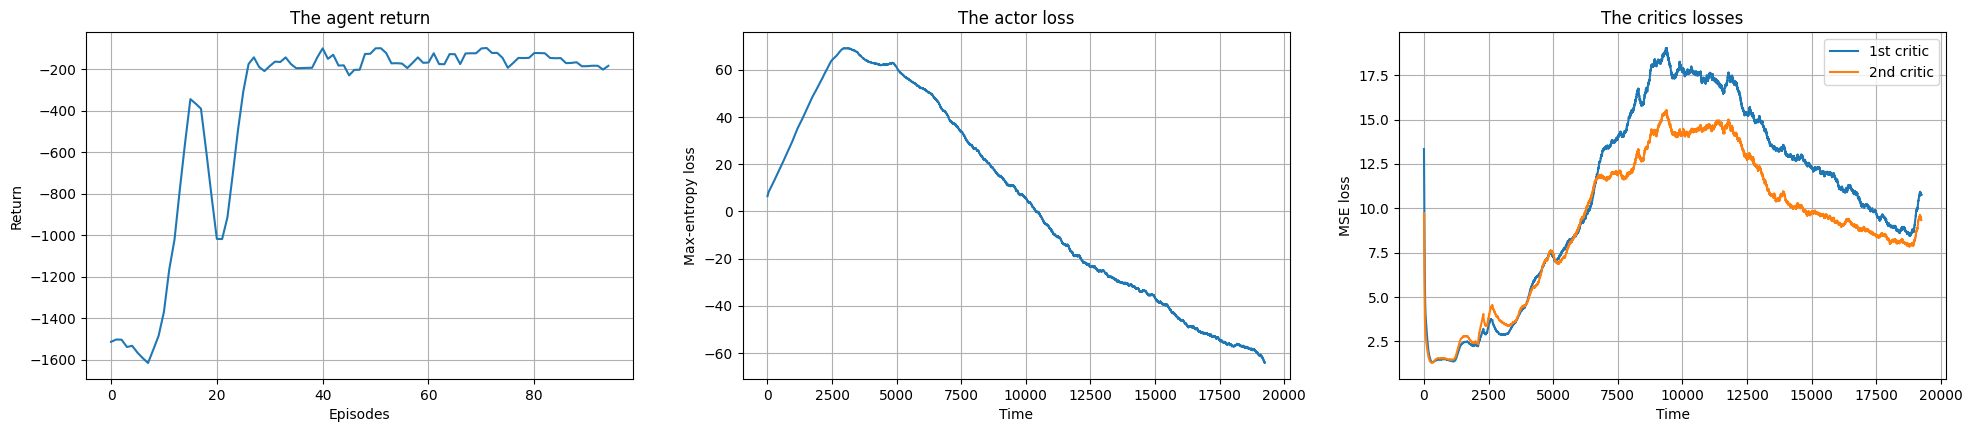

In [ ]:
# Plot the result

def sliding_window(values, span):
    cumsum = np.cumsum(values)
    return (cumsum[span:] - cumsum[:-span]) / float(span)

nrows, ncols = 1, 3
dx, dy = 16, 9
scale = 1.5
figsize = plt.figaspect(float(dy * nrows) / float(dx * ncols)) * scale
plt.figure(figsize=figsize)

plt.subplot(nrows, ncols, 1)

plt.plot(sliding_window(ep_rets, 5))
plt.title('The agent return')
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.grid()

plt.subplot(nrows, ncols, 2)

plt.plot(sliding_window(pi_losses, 200))
plt.title('The actor loss')
plt.xlabel('Time')
plt.ylabel('Max-entropy loss')
plt.grid()

plt.subplot(nrows, ncols, 3)

plt.plot(sliding_window(q1_losses, 200), label='1st critic')
plt.plot(sliding_window(q2_losses, 200), label='2nd critic')
plt.title('The critics losses')
plt.xlabel('Time')
plt.ylabel('MSE loss')
plt.legend()
plt.grid()

plt.show()

In [ ]:
total_ret, total_len = 0, 0
for _ in range(num_test_episodes):
    o, d, ep_len = env.reset()[0], False, 0
    while not (d or (ep_len == max_ep_len)):
        # Take deterministic actions at test time.
        o, r, t1, t2, info = env.step(
            get_action(torch.Tensor(o), True))
        d = t1 or t2
        total_ret += r
        ep_len += 1
    total_len += ep_len
print(f"TEST | Ep. length: {total_len/num_test_episodes:4}; Ep. return: {total_ret/num_test_episodes:4.0f};")

TEST | Ep. length: 200.0; Ep. return: -183;
